# Going Deeper

Notebook / exercise from Lukas Heinrichs Deep Learning course.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

Consider the funcion 

$$f(x) = f(x_1,x_2) = \sin(5x_1) + \cos(8x_2)$$

which we then map to a _rate_ via a sigmoid:

$$r(x) = \sigma(5 f(x)) \in (0,1)$$

and the binomial probability model 

$$p(x,z) = p(z|x)p(x) = \mathrm{Bernoulli}(z|r)p(x)$$

with a data distribution $p(x) = \mathrm{Uniform}(-2,2)$

The following function `get_data` samples from the above joint distribution, and returning features $x$ and labels $z$.


In [2]:
def get_data(N):
    x = np.random.uniform(-2,2,size = (N,2))
    x1,x2 = x[...,0],x[...,1]
    fx = np.sin(5*x1) + np.cos(8*x2)
    r = 1/(1+np.exp(-5*fx))
    y = np.random.binomial(1,r)
    return torch.tensor(x).float(),torch.tensor(y).float()

Sample a dataset of 1000 points and visualize it.

Text(0, 0.5, '$x_1$')

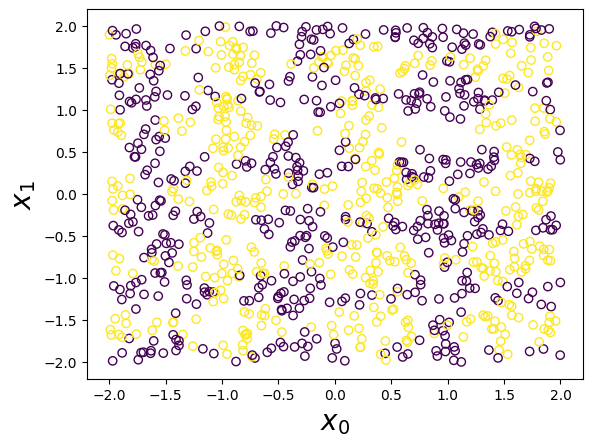

In [3]:
X,y = get_data(1000)
plt.scatter(X[:,0],X[:,1], marker = 'o', facecolor = 'none', edgecolor = plt.get_cmap('viridis')(y))
plt.xlabel('$x_0$',fontsize=20)
plt.ylabel('$x_1$',fontsize=20)

**Step 0:** Look at the data, e.g, what is $y$ for this example?

**Step 1:** Define a training function that accepts a pytorch model and implements the training loop, and returns the pytorch model and loss at each iteration of the training.

In [4]:
# Utility function: count the # of parameters
def count_parameters(model):
    return sum([sum(p.view(-1).shape) for p in model.parameters()])

In [5]:
def train_model(model):
    '''
    To do: Fill in with your new knowledge base how to train a pytorch model
    '''
    
    print(f'training model with {count_parameters(model)} parameters')
    losses = []
    opt = torch.optim.Adam(model.parameters(), 1e-3)
    for i in range(5000): # 5k training steps
        X,y = get_data(5000) # Draw 5000 samples
        p = model(X)
        loss = nn.BCELoss()(p[:,0],y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        '''
        Fill in the missing piece here
        '''
        
        losses.append(float(loss))
        if i % 1000 == 0:
            print(float(loss))
    return model,losses

**Step 2:** Define an MLP with one hidden layer and $H = 300$ hidden units.

In [6]:
H=300
m_s300 = nn.Sequential(nn.Linear(2,H), nn.ReLU(), nn.Linear(H,1), nn.Sigmoid())

In [7]:
m_s300, loss_s300 = train_model(m_s300)

training model with 1201 parameters
0.6965530514717102
0.5991676449775696
0.5309500098228455
0.49856361746788025
0.47557714581489563


**Step 3:** Now let's increase the size of the hypothesis class, increase H: 500, 1500, 7000 NNs

In [8]:
# Define models
m_s500 = nn.Sequential(nn.Linear(2,500), nn.ReLU(), nn.Linear(500,1), nn.Sigmoid())
m_s1500 = nn.Sequential(nn.Linear(2,1500), nn.ReLU(), nn.Linear(1500,1), nn.Sigmoid())
m_s7000 = nn.Sequential(nn.Linear(2,7000), nn.ReLU(), nn.Linear(7000,1), nn.Sigmoid())

# Train them
m_s500,  loss_s500  = train_model(m_s500)
m_s1500, loss_s1500 = train_model(m_s1500)
m_s7000, loss_s7000 = train_model(m_s7000)

training model with 2001 parameters
0.7104636430740356
0.5766693949699402
0.5082200169563293
0.45114073157310486
0.4211138188838959
training model with 6001 parameters
0.7038236260414124
0.5064944624900818
0.4361979365348816
0.37936654686927795
0.3437217175960541
training model with 28001 parameters
0.6881415843963623
0.42127901315689087
0.34412720799446106
0.30693724751472473
0.28451308608055115


**Step 4:** Train a "deep neural network": four hidden layers with H=20 nodes each

In [34]:
H=20
dims = [2] + [H]*4 + [1]

layers = []
for d_in, d_out in zip(dims[:-1],dims[1:]):
    layers.append( torch.nn.Linear(d_in, d_out ) ) 

    # ReLU non-linearities for internal layers
    if d_out != 1:
        layers.append( torch.nn.ReLU() )
    # sigmoid for the final layer (classificiation)
    else:
        layers.append( torch.nn.Sigmoid() )

m_deep = torch.nn.Sequential(*layers)

In [35]:
m_deep, l_deep = train_model(m_deep)

training model with 1341 parameters
0.6974442601203918
0.35432785749435425
0.3282614052295685
0.3134760856628418
0.3127303719520569


**Step 5:** Compare the losses and the # of trainable parameters $\theta$, what have you learned?

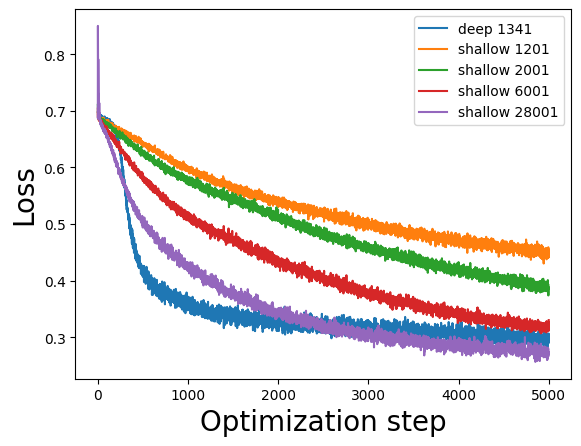

In [36]:
plt.plot(l_deep, label = f'deep {count_parameters(m_deep)}')

for l,m in zip([loss_s300,loss_s500, loss_s1500, loss_s7000],
               [m_s300,m_s500, m_s1500, m_s7000]):
    plt.plot(l, label = f'shallow {count_parameters(m)}')

plt.xlabel('Optimization step',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend()
plt.show()

**Notes:** 
- As we increase the complexity of the shallow network, the loss is still going down, a.k.a, as expected by the universal approxaimation theorem (a wide enough NN should be able to learn any smooth function).
- The deep NN has ~ the same number of parameters as our shallow NN with H=300 hidden units, but is performing ~ as well as the widest shallow NN that we trained. A.k.a, deep is more "memory efficient"

**Bonus:** Visualize the decision boundary for these two NNs

Text(0.5, 1.0, 'Deep NN, four hidden layers with H=20')

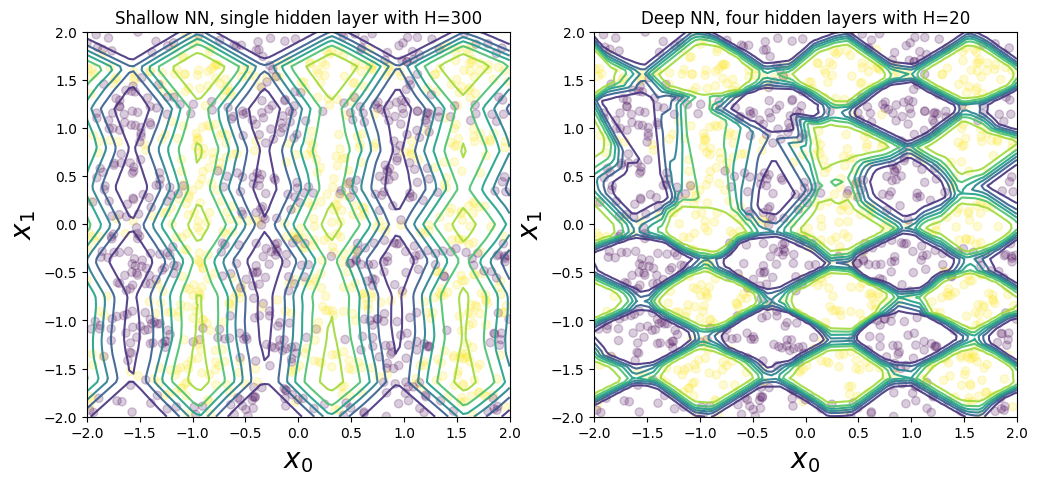

In [40]:
# Generate a grid of the dataset to eval the model on to 
# viz the decision boundaries
grid = np.mgrid[-2:2:101j,-2:2:101j]
X = torch.FloatTensor(np.swapaxes(grid,0,-1).reshape(-1,2))

# Compare to a random sample of events from the training dataset
_X,_y = get_data(1230)

# Draw the decision boundaries, and
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
_pred = m_s300(X).detach()[:,0].reshape(101,101).T
ax1.contour(grid[0],grid[1],_pred, alpha = 0.9)
ax1.scatter(_X[:,0],_X[:,1], c = _y, alpha = 0.2)
ax1.set_xlabel('$x_0$',fontsize=20)
ax1.set_ylabel('$x_1$',fontsize=20)
ax1.set_title('Shallow NN, single hidden layer with H=300')

_pred = m_deep(X).detach()[:,0].reshape(101,101).T
ax2.contour(grid[0],grid[1],_pred, alpha = 0.9)
ax2.scatter(_X[:,0],_X[:,1], c = _y, alpha = 0.2)
ax2.set_xlabel('$x_0$',fontsize=20)
ax2.set_ylabel('$x_1$',fontsize=20)
ax2.set_title('Deep NN, four hidden layers with H=20')


We've learned much more complicated decisaion boundaries (and a better classification) with our deep NN :)

The rest of today (and next week) -- the "tricks" for training these NNs, and going event deeper!!